In [83]:
%matplotlib inline
from __future__ import division, absolute_import
from __future__ import print_function, unicode_literals
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from obspy.geodetics import calc_vincenty_inverse

from mpl_toolkits.mplot3d import Axes3D

from matplotlib import animation, rc
from IPython.display import HTML

from tqdm import tqdm
import re

In [2]:
def plot_map():
    """Harita icin figür hazırlayıp geri döndürür."""
    fig, ax = plt.subplots(figsize=(9, 5), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.set_extent([25, 45, 34,43], crs=ccrs.PlateCarree())
    borders = cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', '50m',
                                           edgecolor="black", facecolor="none")
    coastline = cfeature.NaturalEarthFeature('physical', 'coastline', '50m',
                                             edgecolor="black", facecolor="none")
    ax.add_feature(borders, zorder=2)
    ax.add_feature(coastline, zorder=2)
#     img = plt.imread("harita/turkey.png")
#     img_extent = [25, 45, 34, 43]
#     ax.imshow(img, origin='upper', extent=img_extent, transform=ccrs.PlateCarree(), zorder=1)
    return fig, ax


In [3]:
def get_point_from(lat, lon, dist, az):
    # http://www.movable-type.co.uk/scripts/latlong.html
    rlat = np.radians(lat)
    rlon = np.radians(lon)
    R = 6371.0
    d = dist/R
    lat2 = np.arcsin(np.sin(rlat)*np.cos(d) + np.cos(rlat)*np.sin(d)*np.cos(az))
    lon2 = rlon + np.arctan2(np.sin(az)*np.sin(d)*np.cos(rlat),
                             np.cos(d)-np.sin(rlat)*np.sin(lat2))
    return np.degrees(lat2), np.degrees(lon2)

def get_dist_circle(lat, lon, dist):
    circle = np.linspace(0, 2*np.pi-0.001, 1000)
    cx = []
    cy = []
    for caz in circle:
        a, b = get_point_from(lat, lon, dist, caz)
        cx.append(a)
        cy.append(b)
    return cx, cy

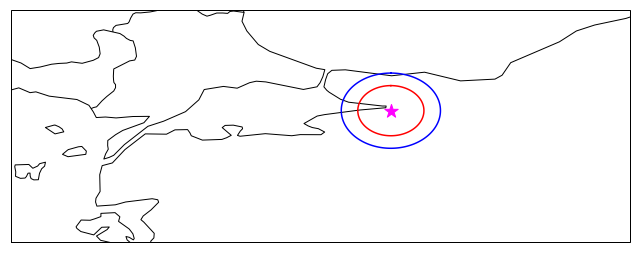

In [4]:
# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plot_map()
lat = 40.70
lon = 29.91
ax.set_extent([25, 33, 39, 42])
ax.scatter(lon, lat, 200, marker="*", color="magenta")
cx, cy = get_dist_circle(lat, lon, 0)
pline, = ax.plot(cy, cx,  color="b", transform=ccrs.Geodetic(), zorder=10)
sline, = ax.plot(cy, cx,  color="r", transform=ccrs.Geodetic(), zorder=10)
fig.tight_layout()

# fig, ax = plt.subplots(subplot_kws={"projection": ccrs.})


# line, = ax.plot([], [], lw=2)

# initialization function: plot the background of each frame
def init():
    pline.set_data([], [])
    return (pline,)

# animation function. This is called sequentially
fps = 1
frames = 10*fps
def animate(i):
    vp = 6.0/fps
    vs = 4.0/fps
    cx, cy = get_dist_circle(lat, lon, vp*i)
    pline.set_data(cy, cx)
    
    cx, cy = get_dist_circle(lat, lon, vs*i)
    sline.set_data(cy, cx)
    return (pline,)

### call the animator. blit=True means only re-draw the parts that have changed.

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=frames, interval=1000.0/fps, blit=True, save_count=frames)

# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='jshtml')
rc


# Writer = animation.writers['ffmpeg']
# writer = Writer(fps=fps, metadata=dict(artist='Me'), bitrate=1800)
# anim.save("waves.avi", writer=writer)

HTML(anim.to_jshtml())

In [65]:
def smooth_ramp_value(rise_time, rupture_time, t):
    # I have no idea what is this supposed to be.
    # I found this:
    # https://www.maplesoft.com/support/help/MapleSim/view.aspx?path=componentLibrary/signalBlocks/sources/real/SmoothRamp(deprecated)
    # Which I implemented like below to behave get values between 0-1. But I didn't like it, so I am using regular ramp.
    #     x = np.arange(0, rise_time+dt, dt)
    #     midx = rise_time/2.0
    #     offset  = 0
    #     y =  0.5 + 0.5*np.tanh((t-midt))
    #     y -= y.min()
    #     y *= 1.0/y.max()
    if t < rupture_time:
        return 0
    elif t > rupture_time + rise_time:
        return 1
    else:
        rt = t - rupture_time
        return 1.0/rise_time*rt

1302it [00:00, 13014.27it/s]

[-0.02617695 -0.99965732  0.        ]
[ 0.  0.  1.]


2922it [00:00, 14591.38it/s]


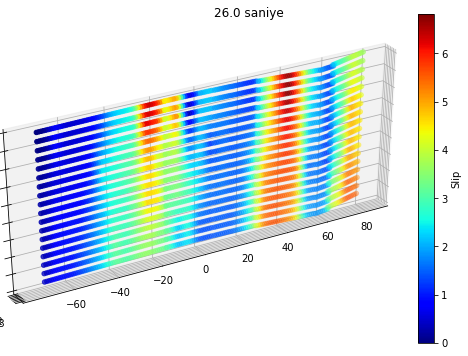

In [92]:
data_started = False

xs = []
ys = []
zs = []
slips = []

strike_r = np.deg2rad(268.5)
dip_r = np.deg2rad(90.0)

strike_v = np.array((np.cos(strike_r), np.sin(strike_r), 0))
strike_v /= np.linalg.norm(strike_v)
dip_v = np.array((0, 0, np.sin(dip_r)))
dip_v /= np.linalg.norm(dip_v)
print(strike_v)
print(dip_v)
was_here = False
pp = None
offsetX = 0
offsetY = 0
read_top_center_next = False
read_len_wid_next = False
source_lat = 0.0
source_lon = 0.0
source_depth = 0.0
center_lat = 0.0
center_lon = 0.0
segment_width = 0
segment_length = 0
rises = []
trups = []


loc = re.compile(
    r"""^% Loc\s+:\s+LAT\s+=\s+(?P<lat>[\.\d]+)\s+LON\s+=\s+(?P<lon>[\.\d]+)\s+DEP\s+=\s+(?P<depth>[\.\d]+)"""
)
segment = re.compile(".*STRIKE\s+=\s+(?P<strike>[\.\d]+)\s+deg\s+DIP\s+=\s+(?P<dip>[\.\d]+)\s+deg.*")
segment2 = re.compile(".*LEN\s+=\s+(?P<len>[\.\d]+)\s+km\s+WID\s+=\s+(?P<wid>[\.\d]+)\s+km.*")

fig, ax = plt.subplots(figsize=(7, 5), subplot_kw={"projection": "3d"})

with open("s1999IZMITT01BOUC.fsp") as f:
    for line in tqdm(f):
        if line.startswith("%"):
#             if data_started is True:
#                 slips = np.array(slips)
# #                 plen = np.max(xs)-np.min(xs)
# #                 pwidth = np.max(ys)-np.min(ys)
# #                 scalex = segment_length/plen
# #                 scaley = segment_width/pwidth
# #                 xs = np.array(xs)*scalex
# #                 ys = np.array(ys)*scaley
                
#                 # fig, ax = plt.subplots(figsize=(14, 12), subplot_kw={"projection": "3d"})
                

#                 patches = []
#                 for x, y in zip(xs, ys):
#                     patches.append(mpatches.Rectangle(
#                         (x, y), 1.0, 1.0
#                     ))
#                 subfaults = PatchCollection(patches, cmap="jet", alpha=1.0)
#                 subfaults.set_array(slips)
#                 ax.add_collection(subfaults)

#                 # sc = ax.scatter(xs, ys, zs, c=slips, cmap="jet")
#                 ax.set_ylim([20, -2])
#                 ax.set_xlim([np.min(xs)*0.8, np.max(xs)*1.2])
#                 xs = []
#                 ys = []
#                 slips = []
#                 data_started = False
                
            if line.startswith("% Loc"):
                m = loc.match(line)
                if m:
                    vals = m.groupdict()
                    source_lat = float(vals["lat"])
                    source_lon = float(vals["lon"])
                    source_depth = float(vals["depth"])
                else:
                    raise Exception("Couldn't read Location line")
            elif read_top_center_next:
                center_lat, center_lon = [
                    float(x.split("=")[1]) for x in line.split(",")
                ]
                read_top_center_next = False
                dist_m, az, baz = calc_vincenty_inverse(
                    source_lat, source_lon, center_lat, center_lon
                )
                dist_km = dist_m / 1000.0
                offsetX = dist_km * np.sin(np.deg2rad(az))
                offsetY = dist_km * np.cos(np.deg2rad(az))
                proj_dist_km = np.dot(np.array((offsetX, offsetY, 0)), strike_v)
            elif "coordinates of top-center:" in line:
                read_top_center_next = True
            elif "SEGMENT # " in line:
                read_len_wid_next = True
                m = segment.match(line)
                if m:
                    vals = m.groupdict()
                    strike_r = np.deg2rad(float(vals["strike"]))
                    dip_r = np.deg2rad(float(vals["dip"]))
                    strike_v = np.array((np.cos(strike_r), np.sin(strike_r), 0))
                    strike_v /= np.linalg.norm(strike_v)
                    dip_v = np.array((0, 0, np.sin(dip_r)))
                    dip_v /= np.linalg.norm(dip_v)
                else:
                    raise Exception("Couldn't read segment line: \n {}".format(line))         
            elif read_len_wid_next:
                read_len_wid_next = False
                m = segment2.match(line)
                if m:
                    vals = m.groupdict()
                    segment_length = float(vals["len"])
                    segment_width = float(vals["wid"])
                else:
                    raise Exception("Couldn't read second segment line.")
        else:
            data_started = True
            lat, lon, x, y, z, slip, rise, trup = [float(x) for x in line.split()]
            dist_m, az, baz = calc_vincenty_inverse(source_lat, source_lon, lat, lon)
            away = dist_m
            az_r = np.deg2rad(az)
            p = np.array((away*np.sin(az_r), away*np.cos(az_r), z))
#             xs.append(lat)
#             ys.append(lon)
            xs.append(x)
            ys.append(y)
            zs.append(z)
            trups.append(trup)
            rises.append(rise)
#             xs.append(np.dot(p, strike_v))
#             ys.append(np.dot(p, dip_v))
#             xs.append(x + offsetX)
#             ys.append(y + offsetY)
#             zs.append(z)
            slips.append(slip)


# slips = np.array(slips)
# fig, ax = plt.subplots(figsize=(14, 12), subplot_kw={"projection": "3d"})
# fig, ax = plt.subplots(figsize=(14, 12))

# patches = []
# for x, y in zip(xs, ys):
#     patches.append(mpatches.Rectangle(
#         (x, y), 1.0, 1.0
#     ))
# subfaults = PatchCollection(patches, cmap="jet", alpha=0.1)
# subfaults.set_array(slips)
# ax.add_collection(subfaults)

# initialization function: plot the background of each frame


slips = np.array(slips)
ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([2.0, 0.1, 1.0, 1]))

sc = ax.scatter(xs, ys, zs, c=np.zeros(len(slips)), cmap="jet")
sc.set_clim([0, np.max(slips)])
ax.view_init(30, -120)
ax.set_zlim([18, 0])
cb = plt.colorbar(sc)
cb.ax.set_ylabel("Slip");
fig.tight_layout()

# animation function. This is called sequentially
fps = 1
frames = 27*fps
def animate(i):
    t = i/fps
    # Overwriting previous one was causing problems, so I replot the whole thing.
    global sc
    sc.remove()
    cur_slips = np.array([smooth_ramp_value(rise, trup, t)*slip for trup, rise, slip in zip(trups, rises, slips)])
    sc = ax.scatter(xs, ys, zs, c=cur_slips, cmap="jet")
    sc.set_clim([0, np.max(slips)])
    fig.suptitle("{:.1f} saniye".format(t))
    return sc,

### call the animator. blit=True means only re-draw the parts that have changed.

anim = animation.FuncAnimation(fig, animate,
                               frames=frames, interval=1000.0/fps, blit=True, save_count=frames)

rc('animation', html='jshtml')

# Writer = animation.writers['ffmpeg']
# writer = Writer(fps=fps, metadata=dict(artist='Me'), bitrate=1800)
# anim.save("bouc_fault.avi", writer=writer)

HTML(anim.to_jshtml())

(0.0, 1.0)


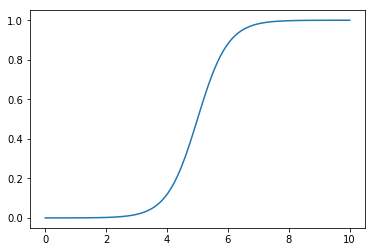

In [57]:
# y= offset + 12⋅(tanh(2⋅k0⋅(t − T0))+1)⋅height

x = np.linspace(0, 10, 100)
midx = x.mean()
offset  = 0
y =  0.5 + 0.5*np.tanh((x-midx))
y -= y.min()
y *= 1.0/y.max()
plt.plot(x, y)
print(y[0], y[-1])
pass

End.